# 3.6.3 Amazon Reviews

In [1]:
%matplotlib inline

import sqlite3
import json
import csv
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from wordcloud import WordCloud, STOPWORDS

## Reading data from JSON file 

In [2]:
df = pd.read_json('Cell_Phones_and_Accessories_5.json', lines=True)

In [3]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,120401325X,"[0, 0]",4,They look good and stick good! I just don't li...,"05 21, 2014",A30TL5EWN6DFXT,christina,Looks Good,1400630400
1,120401325X,"[0, 0]",5,These stickers work like the review says they ...,"01 14, 2014",ASY55RVNIL0UD,emily l.,Really great product.,1389657600
2,120401325X,"[0, 0]",5,These are awesome and make my phone look so st...,"06 26, 2014",A2TMXE2AFO7ONB,Erica,LOVE LOVE LOVE,1403740800
3,120401325X,"[4, 4]",4,Item arrived in great time and was in perfect ...,"10 21, 2013",AWJ0WZQYMYFQ4,JM,Cute!,1382313600
4,120401325X,"[2, 3]",5,"awesome! stays on, and looks great. can be use...","02 3, 2013",ATX7CZYFXI1KW,patrice m rogoza,leopard home button sticker for iphone 4s,1359849600


## New dataframe having only helpful and asin features

In [4]:
helpfulness = df[['helpful','asin']]

In [5]:
helpfulness.head()

,helpful,asin
0,"[0, 0]",120401325X
1,"[0, 0]",120401325X
2,"[0, 0]",120401325X
3,"[4, 4]",120401325X
4,"[2, 3]",120401325X


In [6]:
df2 = pd.DataFrame(helpfulness)

In [7]:
df2[['helpful','total']] = pd.DataFrame(df2.helpful.values.tolist(), index=df2.index)
dfhelpful = df2[['asin', 'helpful','total']]

In [8]:
dfhelpful.head()

,asin,helpful,total
0,120401325X,0,0
1,120401325X,0,0
2,120401325X,0,0
3,120401325X,4,4
4,120401325X,2,3


In [9]:
dfNew = df.drop('helpful',1)

In [10]:
frames = [dfNew, dfhelpful]

In [11]:
result = dfNew.join(dfhelpful[['helpful','total']])

In [12]:
result.head()

,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,helpful,total
0,120401325X,4,They look good and stick good! I just don't li...,"05 21, 2014",A30TL5EWN6DFXT,christina,Looks Good,1400630400,0,0
1,120401325X,5,These stickers work like the review says they ...,"01 14, 2014",ASY55RVNIL0UD,emily l.,Really great product.,1389657600,0,0
2,120401325X,5,These are awesome and make my phone look so st...,"06 26, 2014",A2TMXE2AFO7ONB,Erica,LOVE LOVE LOVE,1403740800,0,0
3,120401325X,4,Item arrived in great time and was in perfect ...,"10 21, 2013",AWJ0WZQYMYFQ4,JM,Cute!,1382313600,4,4
4,120401325X,5,"awesome! stays on, and looks great. can be use...","02 3, 2013",ATX7CZYFXI1KW,patrice m rogoza,leopard home button sticker for iphone 4s,1359849600,2,3


In [13]:
result.to_csv('reviews.csv', sep=',', header=False,index=False)

In [14]:
result.head()

,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,helpful,total
0,120401325X,4,They look good and stick good! I just don't li...,"05 21, 2014",A30TL5EWN6DFXT,christina,Looks Good,1400630400,0,0
1,120401325X,5,These stickers work like the review says they ...,"01 14, 2014",ASY55RVNIL0UD,emily l.,Really great product.,1389657600,0,0
2,120401325X,5,These are awesome and make my phone look so st...,"06 26, 2014",A2TMXE2AFO7ONB,Erica,LOVE LOVE LOVE,1403740800,0,0
3,120401325X,4,Item arrived in great time and was in perfect ...,"10 21, 2013",AWJ0WZQYMYFQ4,JM,Cute!,1382313600,4,4
4,120401325X,5,"awesome! stays on, and looks great. can be use...","02 3, 2013",ATX7CZYFXI1KW,patrice m rogoza,leopard home button sticker for iphone 4s,1359849600,2,3


## Loading csv to SQLite 
Fetch the score and recommendation summary using SQL queries

In [15]:
class csvrd(object):
    def csvFile(self):

        self.readFile('reviews.csv')

    def readFile(self, filename):
        conn = sqlite3.connect('amazonReviews.db')
        cur = conn.cursor() 
        cur.execute("""CREATE TABLE IF NOT EXISTS amazonReviews(asin INT,overall INT,reviewText varchar,reviewTime INTEGER, reviewerID varchar,reviewerName varchar,summary varchar,unixReviewTime INTEGER,helpful INT,total INT)""")
        filename.encode('utf-8')
        print("Amazon Reviews table executed")
        with open(filename) as f:
            reader = csv.reader(f)
            for field in reader:
                cur.execute("INSERT INTO amazonReviews VALUES (?,?,?,?,?,?,?,?,?,?);", field)

        print("CSV Loaded into SQLite")
        conn.commit()
        conn.close()

c = csvrd().csvFile()

Amazon Reviews table executed
CSV Loaded into SQLite


## Reading the data from SQLite

In [16]:
con = sqlite3.connect('amazonReviews.db')

pd.read_sql_query("SELECT * FROM amazonReviews LIMIT 5", con)

,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,helpful,total
0,120401325X,4,They look good and stick good! I just don't li...,"05 21, 2014",A30TL5EWN6DFXT,christina,Looks Good,1400630400,0,0
1,120401325X,5,These stickers work like the review says they ...,"01 14, 2014",ASY55RVNIL0UD,emily l.,Really great product.,1389657600,0,0
2,120401325X,5,These are awesome and make my phone look so st...,"06 26, 2014",A2TMXE2AFO7ONB,Erica,LOVE LOVE LOVE,1403740800,0,0
3,120401325X,4,Item arrived in great time and was in perfect ...,"10 21, 2013",AWJ0WZQYMYFQ4,JM,Cute!,1382313600,4,4
4,120401325X,5,"awesome! stays on, and looks great. can be use...","02 3, 2013",ATX7CZYFXI1KW,patrice m rogoza,leopard home button sticker for iphone 4s,1359849600,2,3


Ignoring the reviews having score equal to 3

In [17]:
reviews = pd.read_sql_query("""
SELECT 
  overall, 
  summary, 
  helpful, 
  total
FROM amazonReviews 
WHERE overall != 3""", con)

In [18]:
reviews.head(5)

,overall,summary,helpful,total
0,4,Looks Good,0,0
1,5,Really great product.,0,0
2,5,LOVE LOVE LOVE,0,0
3,4,Cute!,4,4
4,5,leopard home button sticker for iphone 4s,2,3


Sentiment column depicts the numeric score of being positive or negative
usefulScore column depicts the boolean value of total number of votes

In [19]:
reviews["sentiment"] = reviews["overall"].apply(lambda score: "positive" if score > 3 else "negative")
reviews["usefulScore"] = (reviews["helpful"]/reviews["total"]).apply(lambda n: "useful" if n > 0.8 else "useless")

reviews.head(5)

,overall,summary,helpful,total,sentiment,usefulScore
0,4,Looks Good,0,0,positive,useless
1,5,Really great product.,0,0,positive,useless
2,5,LOVE LOVE LOVE,0,0,positive,useless
3,4,Cute!,4,4,positive,useful
4,5,leopard home button sticker for iphone 4s,2,3,positive,useless


In [20]:
#Rows having overall score equal to 5
reviews[reviews.overall == 5].head(5)

,overall,summary,helpful,total,sentiment,usefulScore
1,5,Really great product.,0,0,positive,useless
2,5,LOVE LOVE LOVE,0,0,positive,useless
4,5,leopard home button sticker for iphone 4s,2,3,positive,useless
5,5,best thing ever..,0,0,positive,useless
7,5,Solid Case,2,3,positive,useless


In [21]:
#Rows having overall score equal to 1
reviews[reviews.overall == 1].head(5)

,overall,summary,helpful,total,sentiment,usefulScore
6,1,not a good Idea,1,2,negative,useless
18,1,Horrible,0,0,negative,useless
30,1,"don't waste your money, pay more and buy one a...",0,0,negative,useless
44,1,Be careful,0,0,negative,useless
67,1,bad experience,0,0,negative,useless


## Feature extraction from reviewsText 
Assign new dimension to each word and give the word counts

In [22]:
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

reviews["summaryClean"] = reviews["summary"].apply(cleanReviews)

train, test = train_test_split(reviews, test_size=0.2)
print("%d items in training data, %d in test data" % (len(train), len(test)))


276800 items in training data, 69200 in test data


In [23]:
train.head()

,overall,summary,helpful,total,sentiment,usefulScore,summaryClean
118236,2,Good Protector but Useless with the Square One...,1,2,negative,useless,good protector but useless with the square one...
162186,5,Lighting in Lightning Speed,3,5,positive,useless,lighting in lightning speed
23723,4,aux,0,0,positive,useless,aux
320327,5,I would buy from this company again,2,3,positive,useless,i would buy from this company again
319897,4,it works well,0,0,positive,useless,it works well


### Using TfidfTransformer().fit_transofrm 
to fit the train and test data

In [24]:
countVector = CountVectorizer(min_df = 1, ngram_range = (1, 4))
X_train_counts = countVector.fit_transform(train["summaryClean"])

#applying tfidf to term frequency
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_new_counts = countVector.transform(test["summaryClean"])
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

y_train = train["sentiment"]
y_test = test["sentiment"]

prediction = dict()

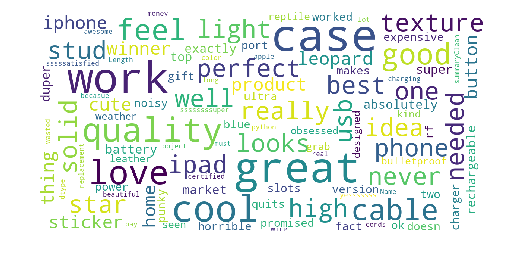

In [25]:
stopwords = set(STOPWORDS)

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(reviews["summaryClean"])

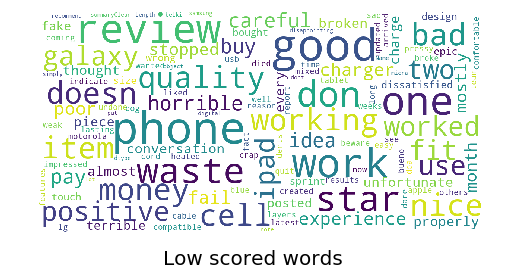

In [26]:
show_wordcloud(reviews[reviews.overall == 1]["summaryClean"], title = "Low scored words")

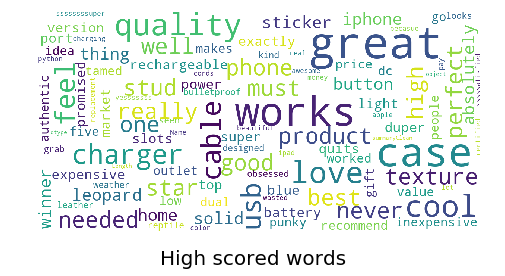

In [27]:
show_wordcloud(reviews[reviews.overall == 5]["summaryClean"], title = "High scored words")

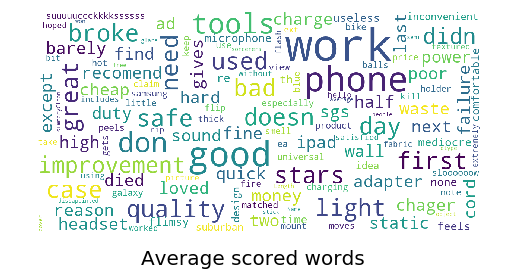

In [28]:
show_wordcloud(reviews[reviews.overall == 2]["summaryClean"], title = "Average scored words")

## Multinomial Naïve Bayes model

In [29]:
model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf)

## Bernoulli Naïve Bayes model

In [30]:
model = BernoulliNB().fit(X_train_tfidf, y_train)
prediction['Bernoulli'] = model.predict(X_test_tfidf)

## Logistic regression model

In [31]:
logreg = LogisticRegression(C=1e5)
logreg_result = logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

### Results

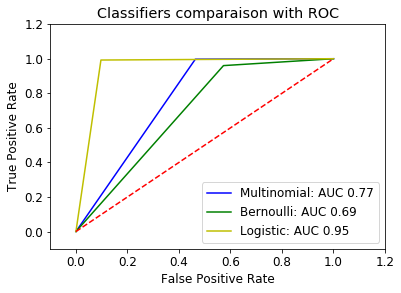

In [32]:
def formatt(x):
    if x == 'negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Visualize the accuracy, recall and f1-score for Logistic Regression

In [33]:
print(metrics.classification_report(y_test, prediction['Logistic'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.95      0.90      0.93      9753
   negative       0.98      0.99      0.99     59447

avg / total       0.98      0.98      0.98     69200



In [34]:
accuracy_score(y_test, prediction['Logistic'])

0.97982658959537572

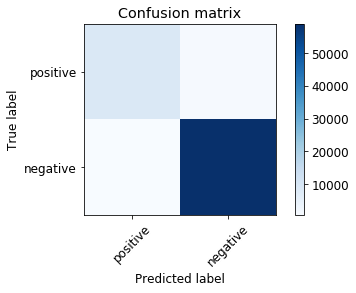

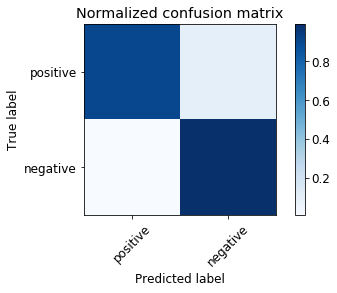

In [35]:
def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
matrix = confusion_matrix(y_test, prediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(matrix)    

matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(matrix_normalized, title='Normalized confusion matrix')
plt.show()

### Visualize the accuracy, recall and f1-score for Naive Bayes Berrnoulli

In [36]:
print(metrics.classification_report(y_test, prediction['Bernoulli'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.64      0.43      0.51      9753
   negative       0.91      0.96      0.93     59447

avg / total       0.87      0.89      0.88     69200



In [37]:
accuracy_score(y_test, prediction['Bernoulli'])

0.88502890173410409

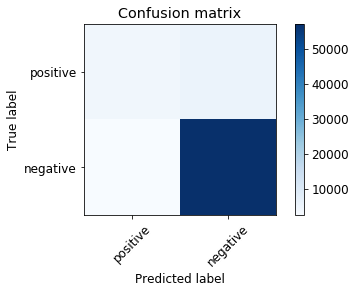

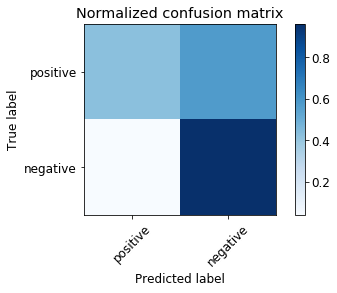

In [38]:
def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
matrix = confusion_matrix(y_test, prediction['Bernoulli'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(matrix)    

matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(matrix_normalized, title='Normalized confusion matrix')
plt.show()

### Visualize the accuracy, recall and f1-score for Naive Bayes Multinomial

In [39]:
print(metrics.classification_report(y_test, prediction['Multinomial'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.97      0.54      0.69      9753
   negative       0.93      1.00      0.96     59447

avg / total       0.93      0.93      0.92     69200



In [40]:
accuracy_score(y_test, prediction['Multinomial'])

0.93221098265895952

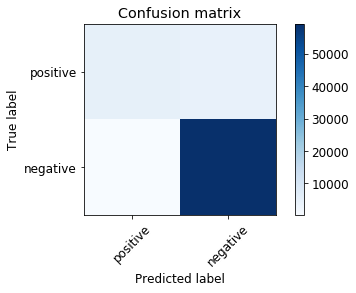

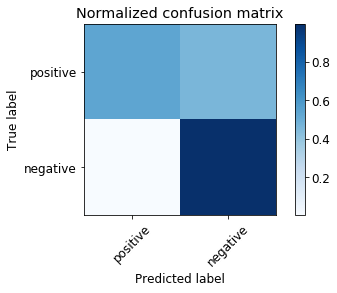

In [41]:
def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
matrix = confusion_matrix(y_test, prediction['Multinomial'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(matrix)    

matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(matrix_normalized, title='Normalized confusion matrix')
plt.show()

### Displaying words depicting the best and worst features

In [42]:
features = countVector.get_feature_names()
feature_coefs = pd.DataFrame(
    data = list(zip(features, logreg_result.coef_[0])),
    columns = ['feature', 'coefficient'])

feature_coefs.sort_values(by='coefficient')

,feature,coefficient
538270,worst,-28.302640
445726,terrible,-25.689390
320084,not,-24.854750
261627,junk,-24.265028
228502,horrible,-23.488275
151619,fake,-22.610468
366452,poor,-22.183440
500345,useless,-21.244179
119548,defective,-21.170848
129558,doesn,-20.866304


### Testing the sentiments of few reviews 

In [43]:
def testSentiments(model, testData):
    testCounts = countVector.transform([testData])
    testTfidf = tfidf_transformer.transform(testCounts)
    result = model.predict(testTfidf)[0]
    probability = model.predict_proba(testTfidf)[0]
    print("Sample estimated as %s: negative prob %f, positive prob %f" % (result.upper(), probability[0], probability[1]))

testSentiments(logreg, "Could have been better.")
testSentiments(logreg, "Just what we expected.")
testSentiments(logreg, "Great, we enjoyed it with my dog!")

Sample estimated as NEGATIVE: negative prob 0.590101, positive prob 0.409899
Sample estimated as POSITIVE: negative prob 0.002173, positive prob 0.997827
Sample estimated as POSITIVE: negative prob 0.000298, positive prob 0.999702


## Testing Logistic Regression with another category dataset

In [44]:
df = pd.read_json('Home_and_Kitchen_5.json', lines=True)

In [45]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0615391206,"[0, 0]",5,My daughter wanted this book and the price on ...,"10 19, 2013",APYOBQE6M18AA,Martin Schwartz,Best Price,1382140800
1,0615391206,"[0, 0]",5,I bought this zoku quick pop for my daughterr ...,"06 18, 2014",A1JVQTAGHYOL7F,Michelle Dinh,zoku,1403049600
2,0615391206,"[26, 27]",4,There is no shortage of pop recipes available ...,"05 5, 2013",A3UPYGJKZ0XTU4,mirasreviews,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000
3,0615391206,"[14, 18]",5,This book is a must have if you get a Zoku (wh...,"08 4, 2011",A2MHCTX43MIMDZ,"M. Johnson ""Tea Lover""",Creative Combos,1312416000
4,0615391206,"[0, 0]",4,This cookbook is great. I have really enjoyed...,"06 7, 2014",AHAI85T5C2DH3,PugLover,A must own if you own the Zoku maker...,1402099200


## New dataframe having only helpful and asin features

In [46]:
helpfulness = df[['helpful','asin']]

In [47]:
helpfulness.head()

,helpful,asin
0,"[0, 0]",0615391206
1,"[0, 0]",0615391206
2,"[26, 27]",0615391206
3,"[14, 18]",0615391206
4,"[0, 0]",0615391206


In [48]:
df2 = pd.DataFrame(helpfulness)

In [49]:
df2[['helpful','total']] = pd.DataFrame(df2.helpful.values.tolist(), index=df2.index)
dfhelpful = df2[['asin', 'helpful','total']]

In [50]:
dfhelpful.head()

,asin,helpful,total
0,0615391206,0,0
1,0615391206,0,0
2,0615391206,26,27
3,0615391206,14,18
4,0615391206,0,0


In [51]:
dfNew = df.drop('helpful',1)

In [52]:
frames = [dfNew, dfhelpful]

In [53]:
result = dfNew.join(dfhelpful[['helpful','total']])

In [54]:
result.head()

,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,helpful,total
0,0615391206,5,My daughter wanted this book and the price on ...,"10 19, 2013",APYOBQE6M18AA,Martin Schwartz,Best Price,1382140800,0,0
1,0615391206,5,I bought this zoku quick pop for my daughterr ...,"06 18, 2014",A1JVQTAGHYOL7F,Michelle Dinh,zoku,1403049600,0,0
2,0615391206,4,There is no shortage of pop recipes available ...,"05 5, 2013",A3UPYGJKZ0XTU4,mirasreviews,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,26,27
3,0615391206,5,This book is a must have if you get a Zoku (wh...,"08 4, 2011",A2MHCTX43MIMDZ,"M. Johnson ""Tea Lover""",Creative Combos,1312416000,14,18
4,0615391206,4,This cookbook is great. I have really enjoyed...,"06 7, 2014",AHAI85T5C2DH3,PugLover,A must own if you own the Zoku maker...,1402099200,0,0


In [55]:
result.to_csv('reviews.csv', sep=',', header=False,index=False)

In [56]:
result.head()

,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,helpful,total
0,0615391206,5,My daughter wanted this book and the price on ...,"10 19, 2013",APYOBQE6M18AA,Martin Schwartz,Best Price,1382140800,0,0
1,0615391206,5,I bought this zoku quick pop for my daughterr ...,"06 18, 2014",A1JVQTAGHYOL7F,Michelle Dinh,zoku,1403049600,0,0
2,0615391206,4,There is no shortage of pop recipes available ...,"05 5, 2013",A3UPYGJKZ0XTU4,mirasreviews,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,26,27
3,0615391206,5,This book is a must have if you get a Zoku (wh...,"08 4, 2011",A2MHCTX43MIMDZ,"M. Johnson ""Tea Lover""",Creative Combos,1312416000,14,18
4,0615391206,4,This cookbook is great. I have really enjoyed...,"06 7, 2014",AHAI85T5C2DH3,PugLover,A must own if you own the Zoku maker...,1402099200,0,0


## Loading csv to SQLite 
Fetch the score and recommendation summary using SQL queries

In [57]:
class csvrd(object):
    def csvFile(self):

        self.readFile('reviews.csv')

    def readFile(self, filename):
        conn = sqlite3.connect('amazonReviews.db')
        cur = conn.cursor() 
        cur.execute("""CREATE TABLE IF NOT EXISTS amazonReviews(asin INT,overall INT,reviewText varchar,reviewTime INTEGER, reviewerID varchar,reviewerName varchar,summary varchar,unixReviewTime INTEGER,helpful INT,total INT)""")
        filename.encode('utf-8')
        print("Amazon Reviews table executed")
        with open(filename) as f:
            reader = csv.reader(f)
            for field in reader:
                cur.execute("INSERT INTO amazonReviews VALUES (?,?,?,?,?,?,?,?,?,?);", field)

        print("CSV Loaded into SQLite")
        conn.commit()
        conn.close()

c = csvrd().csvFile()

Amazon Reviews table executed
CSV Loaded into SQLite


## Reading the data from SQLite

In [58]:
con = sqlite3.connect('amazonReviews.db')

pd.read_sql_query("SELECT * FROM amazonReviews LIMIT 5", con)

,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,helpful,total
0,120401325X,4,They look good and stick good! I just don't li...,"05 21, 2014",A30TL5EWN6DFXT,christina,Looks Good,1400630400,0,0
1,120401325X,5,These stickers work like the review says they ...,"01 14, 2014",ASY55RVNIL0UD,emily l.,Really great product.,1389657600,0,0
2,120401325X,5,These are awesome and make my phone look so st...,"06 26, 2014",A2TMXE2AFO7ONB,Erica,LOVE LOVE LOVE,1403740800,0,0
3,120401325X,4,Item arrived in great time and was in perfect ...,"10 21, 2013",AWJ0WZQYMYFQ4,JM,Cute!,1382313600,4,4
4,120401325X,5,"awesome! stays on, and looks great. can be use...","02 3, 2013",ATX7CZYFXI1KW,patrice m rogoza,leopard home button sticker for iphone 4s,1359849600,2,3


Ignoring the reviews having score equal to 3

In [59]:
reviews = pd.read_sql_query("""
SELECT 
  overall, 
  summary, 
  helpful, 
  total
FROM amazonReviews 
WHERE overall != 3""", con)

In [60]:
reviews.head(5)

,overall,summary,helpful,total
0,4,Looks Good,0,0
1,5,Really great product.,0,0
2,5,LOVE LOVE LOVE,0,0
3,4,Cute!,4,4
4,5,leopard home button sticker for iphone 4s,2,3


Sentiment column depicts the numeric score of being positive or negative
usefulScore column depicts the boolean value of total number of votes

In [61]:
reviews["sentiment"] = reviews["overall"].apply(lambda score: "positive" if score > 3 else "negative")
reviews["usefulScore"] = (reviews["helpful"]/reviews["total"]).apply(lambda n: "useful" if n > 0.8 else "useless")

reviews.head(5)

,overall,summary,helpful,total,sentiment,usefulScore
0,4,Looks Good,0,0,positive,useless
1,5,Really great product.,0,0,positive,useless
2,5,LOVE LOVE LOVE,0,0,positive,useless
3,4,Cute!,4,4,positive,useful
4,5,leopard home button sticker for iphone 4s,2,3,positive,useless


In [62]:
#Rows having overall score equal to 5
reviews[reviews.overall == 5].head(5)

,overall,summary,helpful,total,sentiment,usefulScore
1,5,Really great product.,0,0,positive,useless
2,5,LOVE LOVE LOVE,0,0,positive,useless
4,5,leopard home button sticker for iphone 4s,2,3,positive,useless
5,5,best thing ever..,0,0,positive,useless
7,5,Solid Case,2,3,positive,useless


In [63]:
#Rows having overall score equal to 1
reviews[reviews.overall == 1].head(5)

,overall,summary,helpful,total,sentiment,usefulScore
6,1,not a good Idea,1,2,negative,useless
18,1,Horrible,0,0,negative,useless
30,1,"don't waste your money, pay more and buy one a...",0,0,negative,useless
44,1,Be careful,0,0,negative,useless
67,1,bad experience,0,0,negative,useless


## Feature extraction from reviewsText 
Assign new dimension to each word and give the word counts

In [64]:
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

reviews["summaryClean"] = reviews["summary"].apply(cleanReviews)

train, test = train_test_split(reviews, test_size=0.2)
print("%d items in training data, %d in test data" % (len(train), len(test)))


682098 items in training data, 170525 in test data


In [65]:
train.head()

,overall,summary,helpful,total,sentiment,usefulScore,summaryClean
696397,2,Misleading description,4,6,negative,useless,misleading description
481167,5,"At last, the perfect home coffee-maker",3,3,positive,useful,at last the perfect home coffee maker
390091,4,Best Ice Shaver for Under $100,3,3,positive,useful,best ice shaver for under
574608,5,Love it!,0,0,positive,useless,love it
232973,4,ALMOST perfect pr my i9100,0,0,positive,useless,almost perfect pr my i


### Using TfidfTransformer().fit_transofrm 
to fit the train and test data

In [66]:
countVector = CountVectorizer(min_df = 1, ngram_range = (1, 4))
X_train_counts = countVector.fit_transform(train["summaryClean"])

#applying tfidf to term frequency
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_new_counts = countVector.transform(test["summaryClean"])
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

y_train = train["sentiment"]
y_test = test["sentiment"]

prediction = dict()

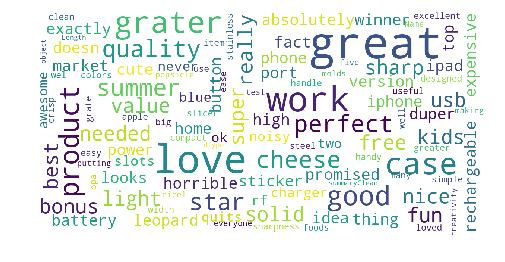

In [67]:
stopwords = set(STOPWORDS)

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(reviews["summaryClean"])

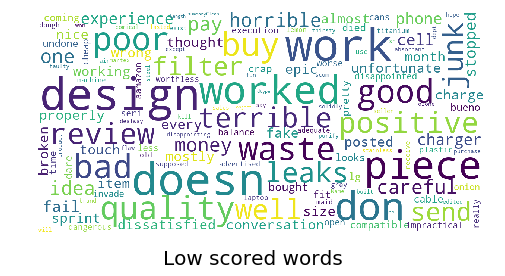

In [68]:
show_wordcloud(reviews[reviews.overall == 1]["summaryClean"], title = "Low scored words")

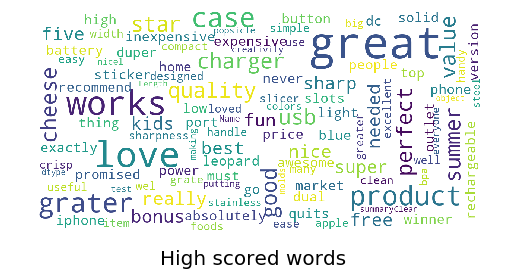

In [69]:
show_wordcloud(reviews[reviews.overall == 5]["summaryClean"], title = "High scored words")

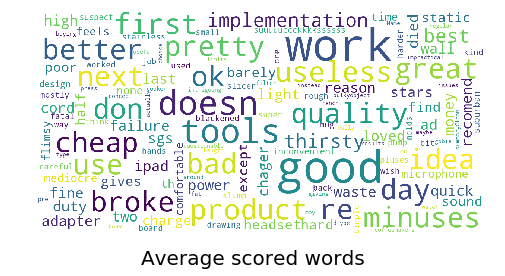

In [70]:
show_wordcloud(reviews[reviews.overall == 2]["summaryClean"], title = "Average scored words")

## Logistic regression model

In [71]:
logreg = LogisticRegression(C=1e5)
logreg_result = logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

### Results

### Visualize the accuracy, recall and f1-score for Logistic Regression

In [72]:
print(metrics.classification_report(y_test, prediction['Logistic'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.88      0.81      0.84     20040
   negative       0.97      0.99      0.98    150485

avg / total       0.96      0.96      0.96    170525



In [73]:
accuracy_score(y_test, prediction['Logistic'])

0.96441577481307728

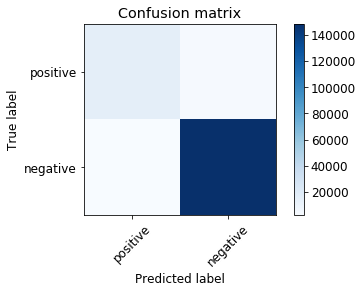

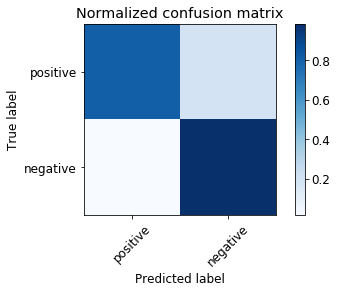

In [74]:
def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
matrix = confusion_matrix(y_test, prediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(matrix)    

matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(matrix_normalized, title='Normalized confusion matrix')
plt.show()

### Displaying words depicting the best and worst features

In [75]:
features = countVector.get_feature_names()
feature_coefs = pd.DataFrame(
    data = list(zip(features, logreg_result.coef_[0])),
    columns = ['feature', 'coefficient'])

feature_coefs.sort_values(by='coefficient')

,feature,coefficient
1772848,worst,-32.382204
1467544,terrible,-26.165149
1197140,poor,-25.447039
1652559,useless,-22.979339
1050525,not,-22.948415
730685,horrible,-22.851251
362365,defective,-22.726285
101853,at best,-21.940187
1198635,poorly,-21.773385
1774592,worthless,-21.644855


### Testing the sentiments of few reviews 

In [76]:
def testSentiments(model, testData):
    testCounts = countVector.transform([testData])
    testTfidf = tfidf_transformer.transform(testCounts)
    result = model.predict(testTfidf)[0]
    probability = model.predict_proba(testTfidf)[0]
    print("Sample estimated as %s: negative prob %f, positive prob %f" % (result.upper(), probability[0], probability[1]))

testSentiments(logreg, "Could have been better.")
testSentiments(logreg, "Just what we expected.")
testSentiments(logreg, "Great, we enjoyed it with my dog!")

Sample estimated as NEGATIVE: negative prob 0.589638, positive prob 0.410362
Sample estimated as POSITIVE: negative prob 0.000779, positive prob 0.999221
Sample estimated as POSITIVE: negative prob 0.000443, positive prob 0.999557


## Conclusion

Three models were used to predict if a review is positive or negative just based on its text. Logistic regression resulted as the one performing the best. We applyied the same procedure to a dataset of a different category, and the accuracy was of 96 per cent.